# Analysis of the used Knowledge Graph

In [1]:
from grape import Graph, GraphVisualizer
import pandas as pd
from KG_analysis import *
import numpy as np
import sys
sys.path.append("..")
from GA4PHphenopackets_utils import *
from KG_utils import *

/home/luci/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nodes = pd.read_csv('../data/nodesL.csv', low_memory=False)
edges = pd.read_csv('../data/edgesL.csv', low_memory=False)

In [3]:
nodes.head()

,name,type
0,<http://purl.obolibrary.org/obo/PR_Q9H425>,Protein
1,<http://purl.obolibrary.org/obo/CHEBI_186730>,Chemical
2,<http://purl.obolibrary.org/obo/CHEBI_191354>,Chemical
3,<http://purl.obolibrary.org/obo/PR_000043907>,Protein
4,<http://purl.obolibrary.org/obo/PR_000004250>,Protein


In [4]:
edges.head()

,subject,predicate,object
0,<http://purl.obolibrary.org/obo/HP_0003392>,Phenotype of,<http://purl.obolibrary.org/obo/MONDO_0011091>
1,<http://purl.obolibrary.org/obo/VO_0016809>,Immunizes against pathogen,<http://purl.obolibrary.org/obo/NCBITaxon_1717>
2,<http://purl.obolibrary.org/obo/CHEBI_174043>,Subclassof,<http://purl.obolibrary.org/obo/CHEBI_25418>
3,<http://purl.obolibrary.org/obo/CHEBI_112546>,Subclassof,<http://purl.obolibrary.org/obo/CHEBI_52898>
4,<https://reactome.org/content/detail/R-HSA-179...,Has participant,<http://www.ncbi.nlm.nih.gov/gene/5906>


In [5]:
g = get_grape_graph(nodes, edges, 'KG')

In [6]:
#g

## Type distribution

### Node types

logarithmic distribution of node types

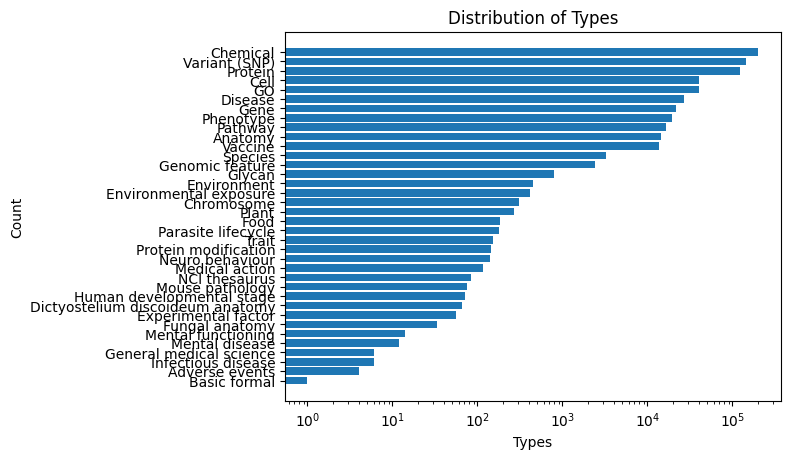

In [7]:
type_counts = nodes['type'].value_counts()
plot_node_type_distribution(type_counts)

#### Percentage of links per node type

In [8]:
n_edges_for_node_type = get_n_edges_for_node_type(edges, nodes)

In [9]:
total_sum = n_edges_for_node_type.sum().sum()
percentage_total = (n_edges_for_node_type / total_sum) * 100

In [10]:
def get_core_based_on_edge_weight(df, percentage):
    df = df.loc[~(df < percentage).all(axis=1)]
    df = df.loc[:, ~(df < percentage).all(axis=0)]
    
    return df

In [11]:
core = get_core_based_on_edge_weight(percentage_total, 0.2)

In [12]:
core_nodes_types = list(set(core.index.append(core.columns)))

In [13]:
len(core_nodes_types)

14

In [14]:
core_nodes = nodes[nodes['type'].isin(core_nodes_types)]

In [15]:
core_edges = edges[edges['subject'].isin(core_nodes['name']) & edges['object'].isin(core_nodes['name'])]

In [16]:
len(core_nodes), len(core_edges)

(669756, 5632793)

In [17]:
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt

def weighed_hypergraph_node_types(df, layout):

    

    g = ig.Graph(directed=True)

    nodes = list(set(df.columns.append(df.index)))
    print(len(nodes))
    g.add_vertices(nodes)
    g.vs['label'] = nodes

    edges = [(x, y) for x in df.index for y in df.columns if df.at[x, y] > 0]
    weights = [df.at[x, y] for x, y in edges]
    print(sorted(weights, reverse=True)[:19])
    # max_weight = max(weights) if weights else 1
    # normalized_weights = [w / max_weight for w in weights]

    
    g.add_edges(edges)

    fig, ax = plt.subplots(figsize=(10, 10))
    layout = g.layout(layout)


    edge_colors = [str(w) for w in weights]
    edge_colors = [f'rgba(0, 0, 0, {w})' for w in edge_colors]

    ig.plot(g, target=ax, layout=layout, vertex_size=30, edge_color=edge_colors, edge_width=2, edge_curved=0.2, edge_loop_size=-1.7)

    plt.show()

In [18]:
import numpy as np

36
[np.float64(13.866400806069715), np.float64(8.044357883352603), np.float64(8.015074550484925), np.float64(6.602631185264117), np.float64(6.033445244234667), np.float64(5.544965300311542), np.float64(4.879017041980204), np.float64(4.874666981662904), np.float64(2.66846139073904), np.float64(2.6675949153099845), np.float64(2.5786839263856622), np.float64(2.5676849933882617), np.float64(2.0790459009169435), np.float64(2.0790459009169435), np.float64(1.8580239338196678), np.float64(1.8580239338196678), np.float64(1.7812612840741462), np.float64(1.7554084865786492), np.float64(1.7435430781521937)]


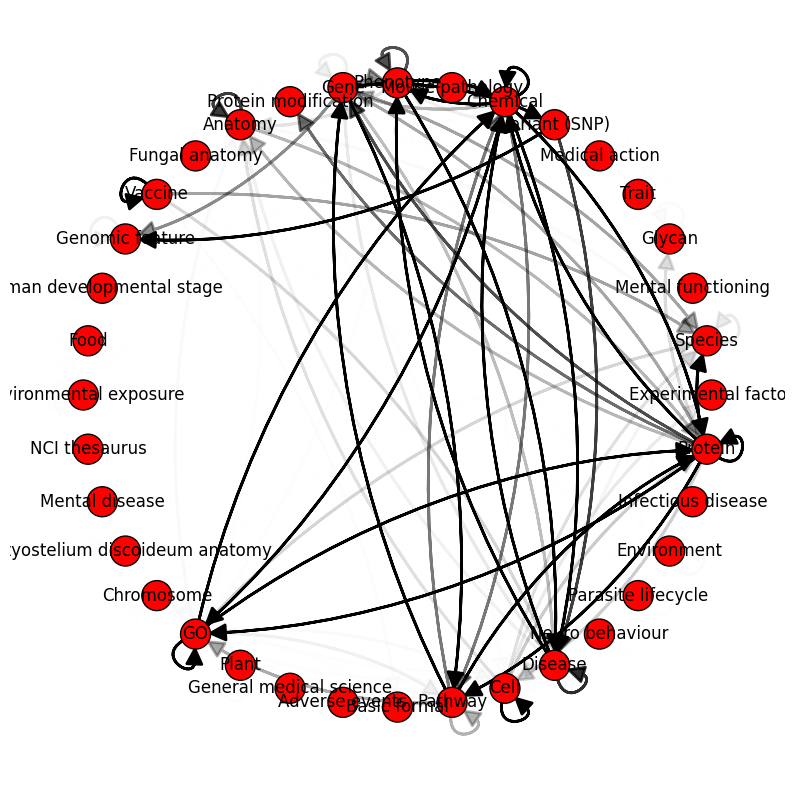

In [19]:
weighed_hypergraph_node_types(percentage_total, 'circle')

14
[np.float64(13.866400806069715), np.float64(8.044357883352603), np.float64(8.015074550484925), np.float64(6.602631185264117), np.float64(6.033445244234667), np.float64(5.544965300311542), np.float64(4.879017041980204), np.float64(4.874666981662904), np.float64(2.66846139073904), np.float64(2.6675949153099845), np.float64(2.5786839263856622), np.float64(2.5676849933882617), np.float64(2.0790459009169435), np.float64(2.0790459009169435), np.float64(1.8580239338196678), np.float64(1.8580239338196678), np.float64(1.7812612840741462), np.float64(1.7554084865786492), np.float64(1.7435430781521937)]


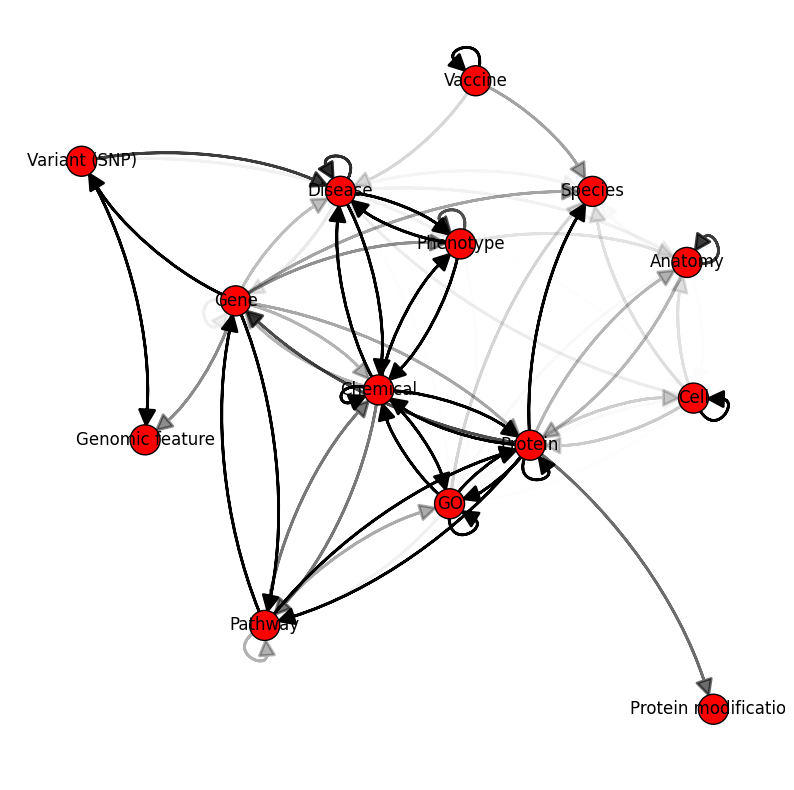

In [20]:
weighed_hypergraph_node_types(core, layout='kk')

For each node type the outward links are weighed on the number of links towards other node types.

In [21]:
# total_sum = links_per_node_t.sum(axis=1)
# percentage_link_counts = (links_per_node_t / total_sum) * 100

In [22]:
# weighed_hypergraph_node_types(percentage_link_counts, layout='kk')

### Edge predicates

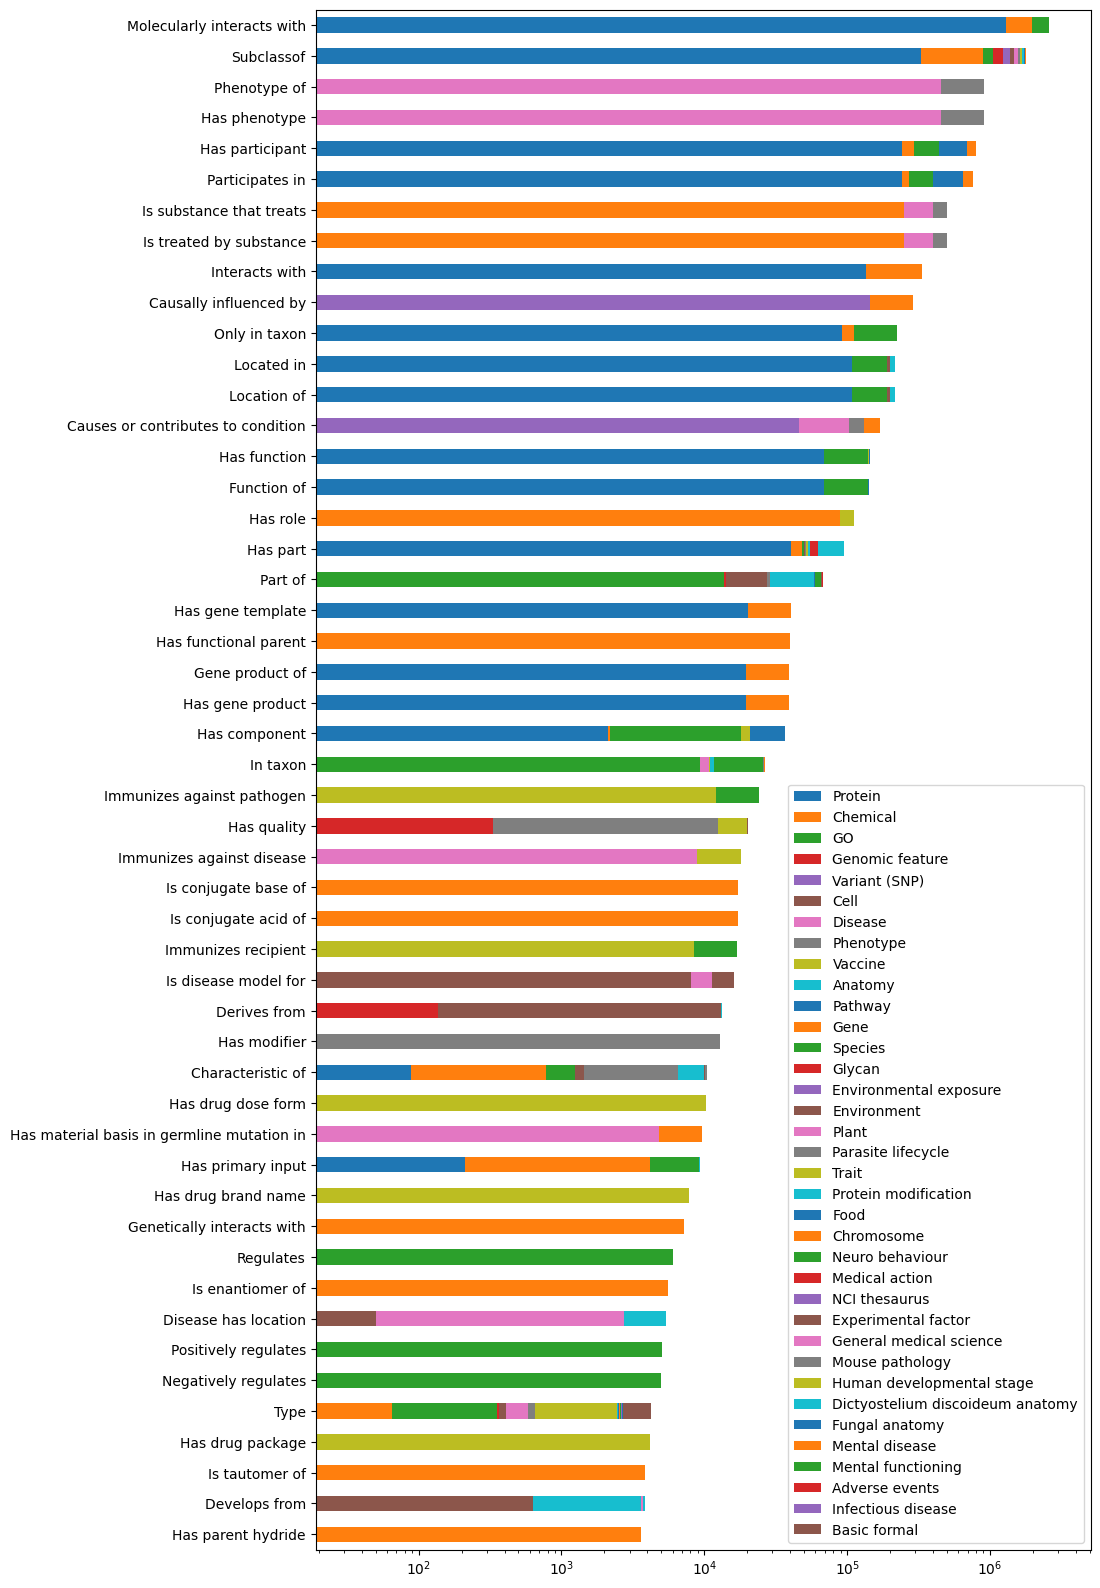

In [23]:
data = pd.DataFrame()
for type in edges['predicate'].value_counts().index[:50]:
    edge_type_data = get_node_types_for_edge_type(edges, nodes, type)
    data = pd.concat([data, edge_type_data], axis=1)
    
data = data.T
    
plot_type_distribution_with_components(data)

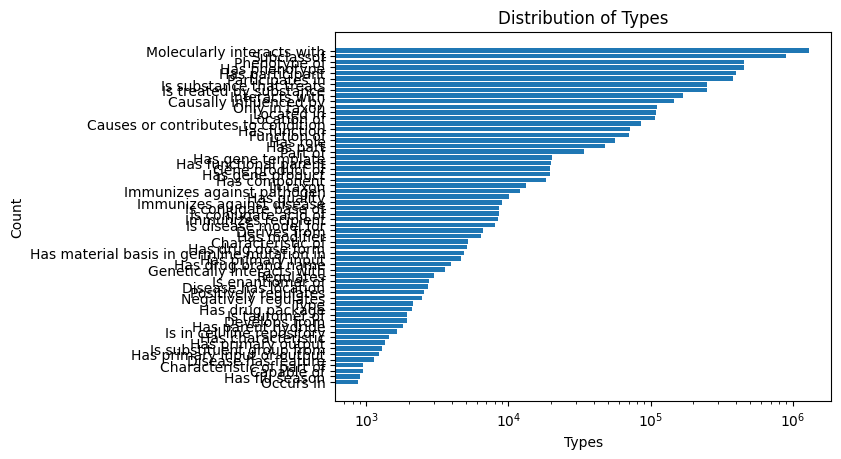

In [ ]:
type_counts = edges['predicate'].value_counts()[:50]
plot_node_type_distribution(type_counts)

## Width measures

### Diameter

In [ ]:
diameter = g.get_diameter()
print(f"Diameter: {diameter}")

## Connectivity

### Neighbourhood size distribution

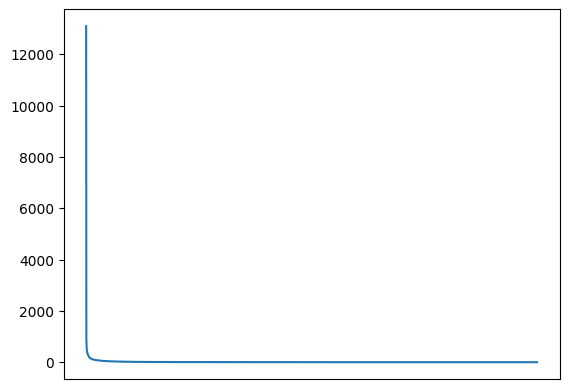

In [ ]:
import matplotlib.pyplot as plt

neighborhood_sizes = {node: g.get_node_degree_from_node_name(node) for node in nodes['name']}

fig, ax = plt.subplots()
plot_distribution(ax, neighborhood_sizes.values(), y_scale='log')

### Neighbourhood size distribution per node type

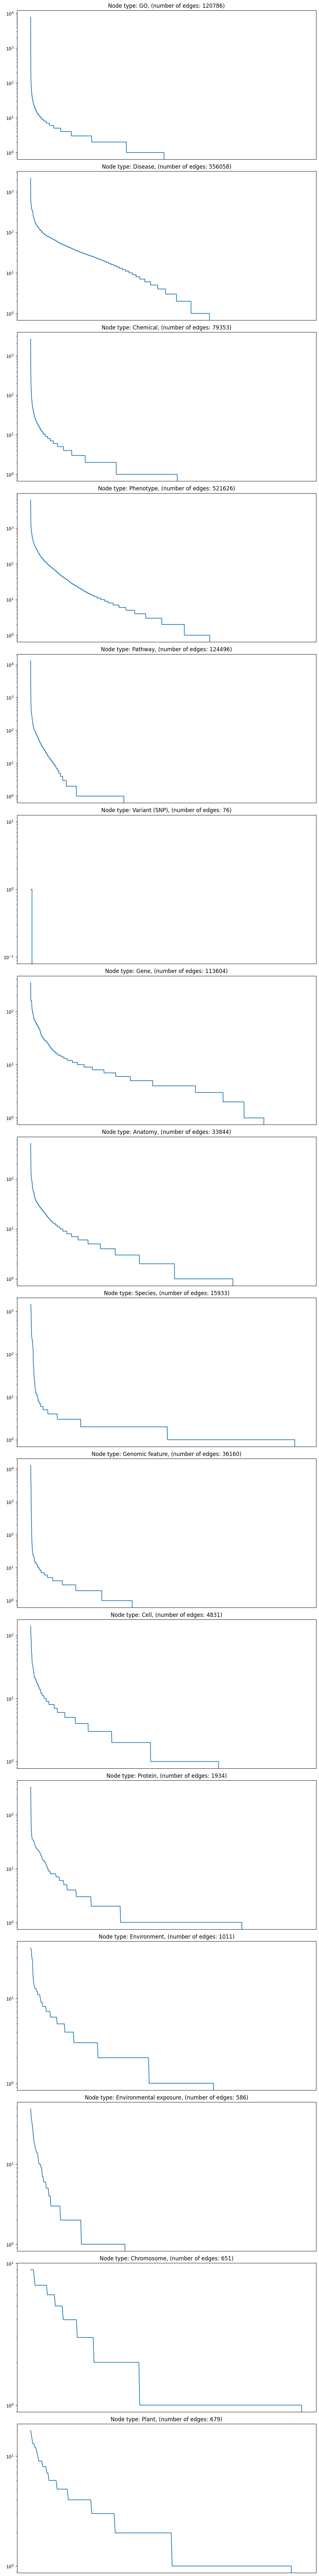

In [ ]:
node_types_vc = nodes['type'].value_counts()
node_types = node_types_vc[node_types_vc > 200].index
fig, axes = plt.subplots(len(node_types), 1, figsize=(10, 5*len(node_types)))
for ax, node_type in zip(axes, node_types):
    neighborhood_sizes = {node: g.get_node_degree_from_node_name(node) for node in nodes[nodes['type']==node_type]['name']}
    ax.set_title(f"Node type: {node_type}, (number of edges: {sum(neighborhood_sizes.values())})")
    plot_distribution(ax, neighborhood_sizes.values(), y_scale='log')
plt.tight_layout()
plt.show()   

### Complementary Cumulative node distribution function

![](./figs/CCD_loglog.png)

### Connected components

In [ ]:
comp = g.get_number_of_connected_components()
print(f"Number of components: {comp[0]}\nNumber of nodes of the smallest component: {comp[1]}\nNumber of nodes of the biggest component: {comp[2]}")

Number of components: 1
Number of nodes of the smallest component: 170958
Number of nodes of the biggest component: 170958


### Centrality

#### Closeness centrality

In [ ]:
closeness_centrality = g.get_closeness_centrality()

Some of the nodes with highest closeness centrality

In [ ]:
node_closeness_centrality={}
for centr in closeness_centrality.nonzero()[0]:
    node_closeness_centrality[g.get_node_name_from_node_id(centr)]=closeness_centrality[centr]
    
for key, value in node_closeness_centrality.items():
    if value ==1:
        print(f"{key}: {value}")

<http://purl.obolibrary.org/obo/CL_0000449>: 1.0
<http://purl.obolibrary.org/obo/CHEBI_16011>: 1.0
<http://purl.obolibrary.org/obo/GO_0140738>: 1.0
<http://purl.obolibrary.org/obo/CHEBI_194508>: 1.0
<http://purl.obolibrary.org/obo/GO_0001777>: 1.0
<http://purl.obolibrary.org/obo/GO_2000569>: 1.0
<http://purl.obolibrary.org/obo/MONDO_1011656>: 1.0
<http://purl.obolibrary.org/obo/CHEBI_17511>: 1.0
<http://purl.obolibrary.org/obo/CHEBI_51120>: 1.0
<http://purl.obolibrary.org/obo/CHEBI_13346>: 1.0
<http://purl.obolibrary.org/obo/CHEBI_28708>: 1.0
<http://purl.obolibrary.org/obo/UBERON_0007302>: 1.0
<http://purl.obolibrary.org/obo/MONDO_0800105>: 1.0
<http://purl.obolibrary.org/obo/GO_0060809>: 1.0
<http://purl.obolibrary.org/obo/CHEBI_13497>: 1.0
<http://purl.obolibrary.org/obo/HP_0034640>: 1.0
<http://purl.obolibrary.org/obo/PW_0001326>: 1.0
<http://purl.obolibrary.org/obo/CHEBI_61165>: 1.0
<http://purl.obolibrary.org/obo/GO_0061966>: 1.0
<http://purl.obolibrary.org/obo/GO_0014802>: 1.0
<

#### Degree centrality

Look at grape description of graph.

## Clusterability

### Global clustering coefficient

In [ ]:
g.get_transitivity()

0.00019900344348588238

In [ ]:
import networkx as nx
G = nx.Graph()

for idx, row in nodes.iterrows():
    G.add_node(row['name'])

# Add edges from edge DataFrame (including attributes if available)
for idx, row in edges.iterrows():
    G.add_edge(row['subject'], row['object'])

### Distribution local clustering coefficients

In [ ]:
node_clustering_coefficients = nx.clustering(G)

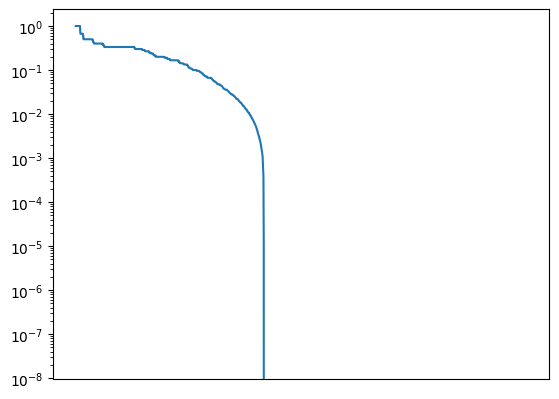

In [ ]:
fig,ax = plt.subplots()

plot_distribution(ax, list(node_clustering_coefficients.values()), y_scale='log')

## Tree-likeness

### Tree width

In [ ]:
treewidth, decomposition = nx.approximation.treewidth_min_degree(G)

print(f"Approximate treewidth of the graph: {treewidth}")

KeyboardInterrupt: 

## Visualization through embedding

### Node2vec

![](./figs/hpo_0_node2vec.png)

### DeepWalk

![](./figs/hpo_0_deep_walk.png)

### LINE

![](./figs/hpo_0_LINE.png)

In [ ]:
patient_conn=pd.read_csv('../data/patient_connections.csv')

In [ ]:
patient_conn

,patient_id,source_label,dest_id,dest_label,patient_idx
0,PMID_15266616_100,11q_terminal_deletion,OMIM:147791,Jacobsen syndrome,0
1,PMID_15266616_101,11q_terminal_deletion,OMIM:147791,Jacobsen syndrome,1
2,PMID_15266616_102,11q_terminal_deletion,OMIM:147791,Jacobsen syndrome,2
3,PMID_15266616_103,11q_terminal_deletion,OMIM:147791,Jacobsen syndrome,3
4,PMID_15266616_104,11q_terminal_deletion,OMIM:147791,Jacobsen syndrome,4
...,...,...,...,...,...
71660,PMID_33776626_fetus,ZSWIM6,HP:0002084,Encephalocele,7829
71661,PMID_33776626_fetus,ZSWIM6,HP:0001841,Preaxial foot polydactyly,7829
71662,PMID_33776626_fetus,ZSWIM6,HP:0000316,Hypertelorism,7829
71663,PMID_33776626_fetus,ZSWIM6,HP:0025706,Absent fetal nasal bone,7829


In [ ]:
nodes.head()

,name,type
0,<http://purl.obolibrary.org/obo/CL_0000449>,Cell
1,<http://purl.obolibrary.org/obo/HP_0034821>,Phenotype
2,<http://purl.obolibrary.org/obo/SO_0001953>,Genomic feature
3,<https://www.ncbi.nlm.nih.gov/snp/rs147324129>,Variant (SNP)
4,<http://purl.obolibrary.org/obo/HP_0030635>,Phenotype


In [ ]:
patient_conn = pd.read_csv('../data/patient_connections.csv', low_memory=False)
omim_mondo_map = pd.read_csv('../data/omim_MONDO_map.txt', sep = '\t', low_memory=False, names = ['omim_id', 'mondo_id'])

In [ ]:
patient_conn

,Unnamed: 0,patient_id,source_label,dest_id,dest_label,patient_idx
0,0,PMID_15266616_100,11q_terminal_deletion,OMIM:147791,Jacobsen syndrome,0
1,1,PMID_15266616_101,11q_terminal_deletion,OMIM:147791,Jacobsen syndrome,1
2,2,PMID_15266616_102,11q_terminal_deletion,OMIM:147791,Jacobsen syndrome,2
3,3,PMID_15266616_103,11q_terminal_deletion,OMIM:147791,Jacobsen syndrome,3
4,4,PMID_15266616_104,11q_terminal_deletion,OMIM:147791,Jacobsen syndrome,4
...,...,...,...,...,...,...
71660,71660,PMID_33776626_fetus,ZSWIM6,HP:0002084,Encephalocele,7829
71661,71661,PMID_33776626_fetus,ZSWIM6,HP:0001841,Preaxial foot polydactyly,7829
71662,71662,PMID_33776626_fetus,ZSWIM6,HP:0000316,Hypertelorism,7829
71663,71663,PMID_33776626_fetus,ZSWIM6,HP:0025706,Absent fetal nasal bone,7829


In [ ]:
patient_hpo = patient_conn[patient_conn['dest_id'].str.startswith('HP:')]

In [ ]:
patient_hpo = patient_hpo['dest_id']

In [ ]:
patient_hpo

7830     HP:0000348
7831     HP:0011220
7832     HP:0000337
7833     HP:0002553
7834     HP:0010487
            ...    
71660    HP:0002084
71661    HP:0001841
71662    HP:0000316
71663    HP:0025706
71664    HP:0004987
Name: dest_id, Length: 63835, dtype: object

In [ ]:
node_hpo = nodes[nodes['name'].str.contains("HP")]

In [ ]:
node_hpo = node_hpo['name'].apply(lambda col: col.split("/")[-1].replace('_', ':')[:-1])

In [ ]:
import numpy as np

not_in_arr2 = patient_hpo[~np.isin(patient_hpo, node_hpo)]

In [ ]:
not_in_arr2.unique()

array([], dtype=object)

In [ ]:
for i in not_in_arr2[not_in_arr2=='HP:0030214'].index:
    patient_conn.loc[i, 'dest_id'] = 'HP:5200321'
    patient_conn.loc[i, 'dest_name'] = 'Amplification of sexual behavior'

In [ ]:
for i in not_in_arr2[not_in_arr2=='HP:0002355'].index:
    patient_conn.loc[i, 'dest_id'] = 'HP:0001288'
    patient_conn.loc[i, 'dest_name'] = 'Gait disturbance'

In [ ]:
for i in not_in_arr2[not_in_arr2=='HP:0006919'].index:
    patient_conn.loc[i, 'dest_id'] = 'HP:0000718'
    patient_conn.loc[i, 'dest_name'] = 'Aggressive behaviour'

In [ ]:
patient_conn.to_csv('../data/patient_connections.csv', index=False)